# Task: classification of fire brigade, police car, rescue car
## ResNet

In [1]:
import numpy as np
import tensorflow as tf 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split

# Constants

In [2]:
IMAGE_DIR = './images/train/'
TEST_IMAGE_DIR = './images/test/'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE  = 32
EPOCHS = 80

# Helper functions

In [3]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            print("skip broken image")
            pass
            
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

from datetime import datetime
logdir = "logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Create Generators

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.3) # set validation split

train_generator = train_datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    IMAGE_DIR, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation') # set as validation data

test_generator =  train_datagen.flow_from_directory(
    TEST_IMAGE_DIR, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True) # set as validation data

Found 210 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 161 images belonging to 3 classes.


# Print some information

In [5]:
print(train_generator.class_indices)

{'fire': 0, 'police': 1, 'rescue': 2}


# Display sample images

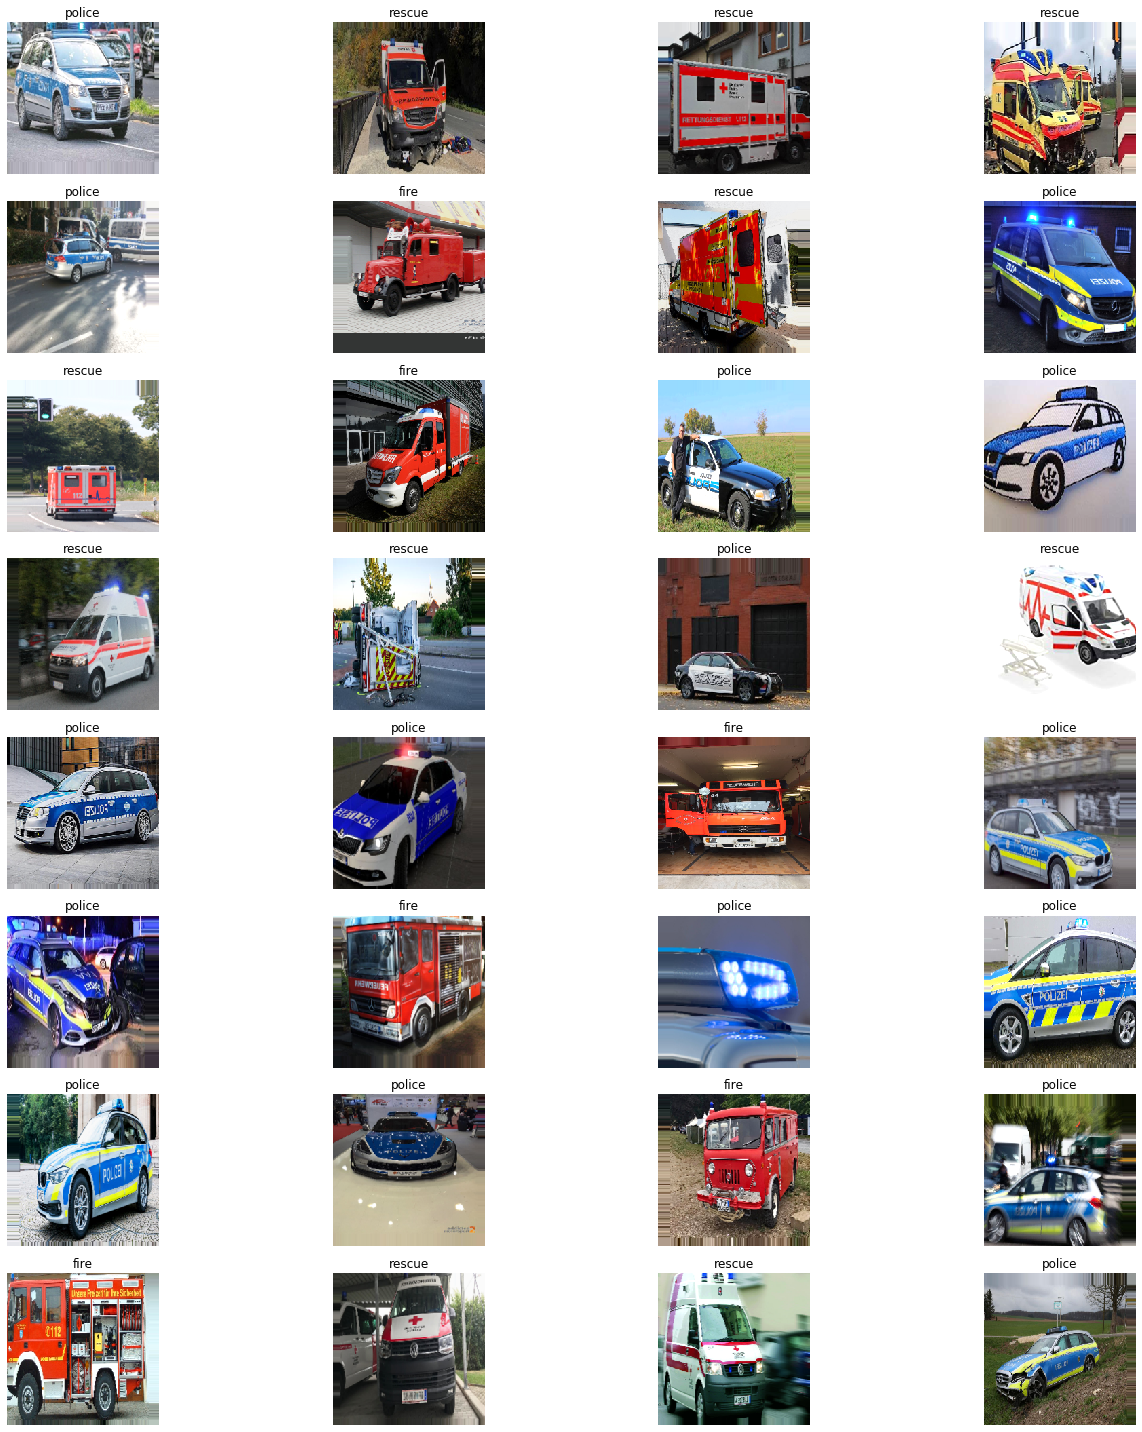

In [6]:
sample_training_images, labels = next(test_generator)
class_label = {v:k for k,v in train_generator.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Create model

In [7]:
from functools import partial
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [8]:
#resnet

model = tf.keras.models.Sequential()
model.add(DefaultConv2D(16, kernel_size=7, strides=2,
                        input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 16
for filters in [16] * 3 + [32] * 4 + [64] * 5:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(train_generator.num_classes, activation="softmax"))



model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      2352      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 16)        4736      
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 16)        4736      
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 16)        4

In [9]:
model.layers

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', tf.keras.metrics.AUC(name="auc")])


In [12]:
history = model.fit_generator(
    skip_broken_images(train_generator),
    steps_per_epoch=train_generator.n / train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=skip_broken_images(validation_generator),
    validation_steps=5,
    callbacks=[snapshot_callback, tensorboard_callback]
)



Epoch 1/80
6/6 [==========================>...] - ETA: 1s - loss: 1.2547 - categorical_accuracy: 0.4844 - auc: 0.6566
Epoch 00001: saving model to ./snapshots
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./snapshots\assets
7/6 [================================] - 39s 6s/step - loss: 1.1899 - categorical_accuracy: 0.4952 - auc: 0.6756 - val_loss: 1.2917 - val_categorical_accuracy: 0.3487 - val_auc: 0.5983
Epoch 2/80
6/6 [==========================>...] - ETA: 0s - loss: 0.8564 - categorical_accuracy: 0.6250 - auc: 0.8313
Epoch 00002: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
7/6 [================================] - 36s 5s/step - loss: 0.8331 - categorical_accuracy: 0.6429 - auc: 0.8380 - val_loss: 1.0664 - val_categorical_accuracy: 0.3355 - val_auc: 0.6273
Epoch 3/80
6/6 [==========================>...] - ETA: 0s - loss: 0.7265 - categorical_accuracy: 0.6875 - auc: 0.8618
Epoch

6/6 [==========================>...] - ETA: 0s - loss: 0.1274 - categorical_accuracy: 0.9531 - auc: 0.9953
Epoch 00020: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
7/6 [================================] - 35s 5s/step - loss: 0.2007 - categorical_accuracy: 0.9381 - auc: 0.9918 - val_loss: 2.6272 - val_categorical_accuracy: 0.3158 - val_auc: 0.5490
Epoch 21/80
6/6 [==========================>...] - ETA: 0s - loss: 0.1482 - categorical_accuracy: 0.9271 - auc: 0.9942
Epoch 00021: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
7/6 [================================] - 37s 5s/step - loss: 0.1431 - categorical_accuracy: 0.9286 - auc: 0.9945 - val_loss: 3.4346 - val_categorical_accuracy: 0.3158 - val_auc: 0.5428
Epoch 22/80
6/6 [==========================>...] - ETA: 0s - loss: 0.3269 - categorical_accuracy: 0.8802 - auc: 0.9718
Epoch 00022: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets


Epoch 41/80
6/6 [==========================>...] - ETA: 0s - loss: 0.0809 - categorical_accuracy: 0.9531 - auc: 0.9983
Epoch 00041: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
7/6 [================================] - 41s 6s/step - loss: 0.0717 - categorical_accuracy: 0.9571 - auc: 0.9986 - val_loss: 1.1834 - val_categorical_accuracy: 0.7105 - val_auc: 0.8525
Epoch 42/80
6/6 [==========================>...] - ETA: 0s - loss: 0.0331 - categorical_accuracy: 0.9896 - auc: 0.9999
Epoch 00042: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
7/6 [================================] - 36s 5s/step - loss: 0.0727 - categorical_accuracy: 0.9714 - auc: 0.9990 - val_loss: 1.1568 - val_categorical_accuracy: 0.6974 - val_auc: 0.8473
Epoch 43/80
6/6 [==========================>...] - ETA: 0s - loss: 0.1570 - categorical_accuracy: 0.9479 - auc: 0.9911
Epoch 00043: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snaps

7/6 [================================] - 36s 5s/step - loss: 0.0735 - categorical_accuracy: 0.9810 - auc: 0.9985 - val_loss: 0.9226 - val_categorical_accuracy: 0.7829 - val_auc: 0.9265
Epoch 62/80
6/6 [==========================>...] - ETA: 0s - loss: 0.0468 - categorical_accuracy: 0.9740 - auc: 0.9994
Epoch 00062: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
7/6 [================================] - 43s 6s/step - loss: 0.1005 - categorical_accuracy: 0.9714 - auc: 0.9962 - val_loss: 0.4071 - val_categorical_accuracy: 0.8684 - val_auc: 0.9632
Epoch 63/80
6/6 [==========================>...] - ETA: 0s - loss: 0.0447 - categorical_accuracy: 0.9896 - auc: 0.9995
Epoch 00063: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
7/6 [================================] - 36s 5s/step - loss: 0.0893 - categorical_accuracy: 0.9810 - auc: 0.9982 - val_loss: 0.7774 - val_categorical_accuracy: 0.7632 - val_auc: 0.9153
Epoch 64/80
6/6 [

# Plot confusion matrix & ROC

In [13]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc(pred, compare):
    line_width = 2
    number_classes = 3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for class_num in range(number_classes):
        comp_temp = []
        pred_temp = []
        for idx in range(len(compare)):
            if compare[idx] == class_num:
                comp_temp.append(1)
            else:
                comp_temp.append(0)
            if pred[idx] == class_num:
                pred_temp.append(1)
            else:
                pred_temp.append(0)   
        fpr[class_num], tpr[class_num], _ = roc_curve(comp_temp, pred_temp)
        roc_auc[class_num] = auc(fpr[class_num], tpr[class_num])
    
    colors = cycle(['darkorange', 'cornflowerblue', 'red'])
    for i, color in zip(range(number_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(class_label[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC One vs. all multi-class')
    plt.legend(loc="lower right")
    plt.show()

# Predictions

In [14]:
sample_test_images, labels_test = next(test_generator)
print(np.argmax(labels, axis=1))

[1 2 2 2 1 0 2 1 2 0 1 1 2 2 1 2 1 1 0 1 1 0 1 1 1 1 0 1 0 2 2 1]


In [15]:
def make_predictions(model, images, labels): 
    pred = model.predict(images )
    pred = np.argmax(pred,axis=1)
    compare = np.argmax(labels, axis=1)
    return pred, compare

In [16]:
pred, compare = make_predictions(model, sample_test_images, labels_test)
print(pred)
print(compare)

[0 0 1 1 0 1 1 1 1 2 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1]
[0 0 1 1 0 1 1 1 2 2 1 1 1 0 0 1 1 0 2 1 1 0 2 1 1 1 0 1 1 0 0 2]


# Metric: Accuracy

In [17]:
from sklearn import metrics

score = metrics.accuracy_score(compare, pred)
print("Accuracy score: {}".format(score))



Accuracy score: 0.8125


# Metric: Accuracy

In [18]:
def plot_history(history): 
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

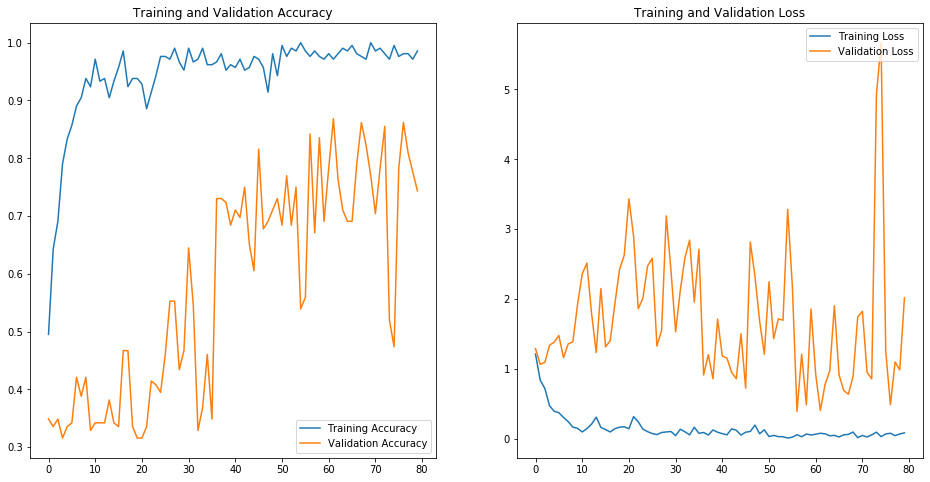

In [19]:
plot_history(history)


# Metric: AUC

In [20]:
def plot_auc(history): 
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs_range = range(EPOCHS)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, auc, label='AUC')
    plt.plot(epochs_range, val_auc, label='Validation AUC')
    plt.legend(loc='upper right')
    plt.title('Training and Validation AUC')
    plt.show() 

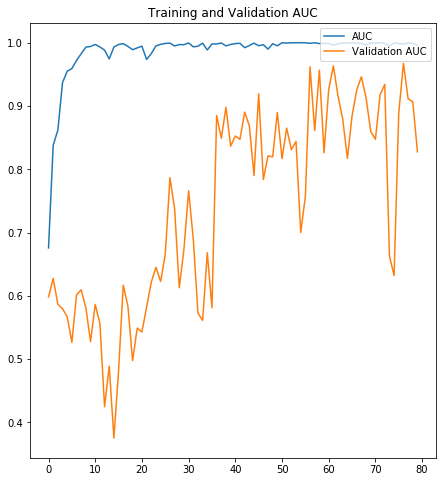

In [21]:
plot_auc(history) 


# Metric: Confusion Matrix 

In [22]:
from sklearn.metrics import confusion_matrix
def plot_metric_confusion_matrix(compare, pred):
    # Compute confusion matrix
    class_labels = {v:k for k,v in test_generator.class_indices.items()}
    cm = confusion_matrix(compare, pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, list(class_labels.values()))

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, list(class_labels.values()), title='Normalized confusion matrix')

    plt.show()

Confusion matrix, without normalization
[[ 8  2  0]
 [ 0 17  0]
 [ 0  4  1]]
Normalized confusion matrix
[[0.8 0.2 0. ]
 [0.  1.  0. ]
 [0.  0.8 0.2]]


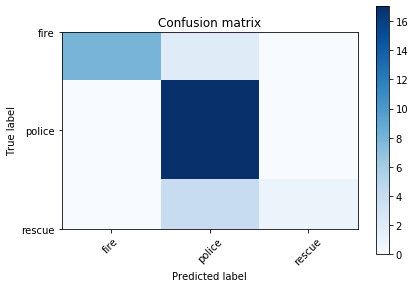

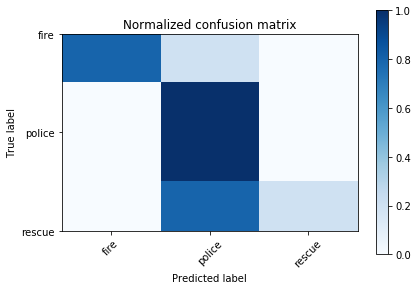

In [23]:
plot_metric_confusion_matrix(compare, pred)

# Metric: ROC

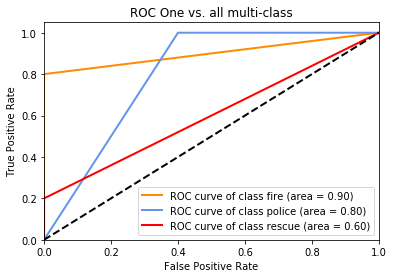

In [24]:
plot_roc(pred,compare)

# Testing predictions

In [25]:
def testing_predictions(model): 
    sample_training_images, labels = next(test_generator)
    class_label = {v:k for k,v in train_generator.class_indices.items()}
    fig, axes = plt.subplots(8, 4, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(sample_training_images, axes):
        img2 = np.expand_dims(img, axis=0)
        result = model.predict_classes(img2)
        ax.set_title(class_label[result[0]])
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()

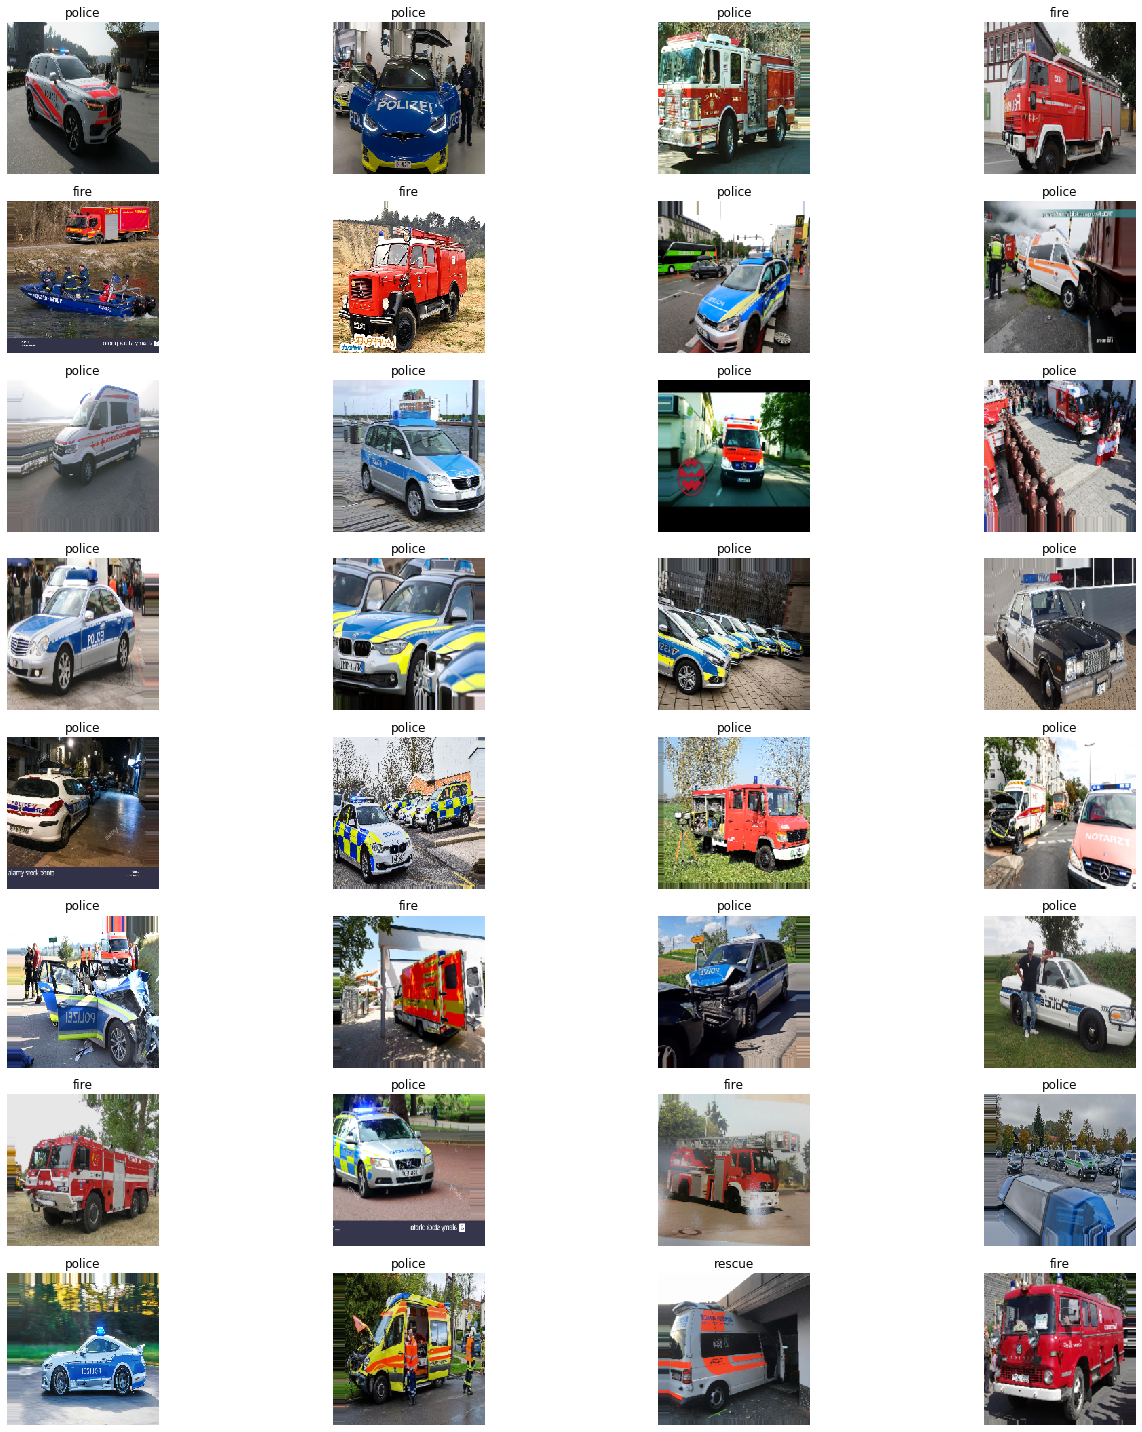

In [26]:
testing_predictions(model)
